In [1]:
import numpy as np
import pandas as pd
from choicedesign.design import EffDesign
from choicedesign.utils import _condgen, _initdesign
from biogeme.expressions import Beta, Variable, bioDraws, exp

# =========================
# Step 1: Random Init Setup
# =========================
def force_random_init(levs, names, ncs=12, seed=2550):
    np.random.seed(seed)
    design = {}
    for i, levels in enumerate(levs):
        col = np.random.choice(levels, size=ncs, replace=True)
        design[names[i]] = col
    return pd.DataFrame(design)

# =========================
# Step 2: Define Attributes
# =========================
alts = ['A', 'B']
atts = [
    # Door Attributes
    {'name': 'D2D',  'levels': [0, 10, 30, 70], 'avail': alts, 'fixed': None},
    {'name': 'D2E',  'levels': [0, 40, 80],     'avail': alts, 'fixed': None},
    {'name': 'O',    'levels': [0, 1],          'avail': alts, 'fixed': None},
    {'name': 'CD',   'levels': [0, 5, 10],      'avail': alts, 'fixed': None},
    {'name': 'CP',   'levels': [1, 4],          'avail': alts, 'fixed': None},

    # CTD dummy-coded (base = None)
    {'name': 'CTD_green',  'levels': [0, 1], 'avail': alts, 'fixed': None},
    {'name': 'CTD_yellow', 'levels': [0, 1], 'avail': alts, 'fixed': None},
    {'name': 'CTD_red',    'levels': [0, 1], 'avail': alts, 'fixed': None},

    # Discount
    {'name': 'D',    'levels': [0, 10, 25, 50], 'avail': alts, 'fixed': None},

    # Timing
    {'name': 'T2DR', 'levels': [1, 2, 4],   'avail': alts, 'fixed': None},
    {'name': 'T2DS', 'levels': [0, 5, 10],     'avail': alts, 'fixed': None},

     # TS = 0 → current trip, TS = 1 → subsequent trip shown
     {'name': 'TS',    'levels': [0, 1], 'avail': alts, 'fixed': None},

    # TR dummy-coded (base = No)
    {'name': 'TR_doorchange', 'levels': [0, 1], 'avail': alts, 'fixed': None},
    {'name': 'TR_nochange',   'levels': [0, 1], 'avail': alts, 'fixed': None}
]

# =========================
# Step 3: Initialize Design Object
# =========================
design = EffDesign(atts_list=atts, alts=alts, ncs=12)

# =========================
# Step 4: Define Feasible Constraints
# =========================
cond = [

    # =============================
    # 1. Shared Timing & TS Logic
    # =============================
    'A_T2DR == B_T2DR',

    '~(A_TS == 1) | (A_T2DS > 0)',
    '~(B_TS == 1) | (B_T2DS > 0)',
    '~(A_TS == 0) | (A_T2DS == 0)',
    '~(B_TS == 0) | (B_T2DS == 0)',
    '~((A_TS == 1) & (B_TS == 1)) | (A_T2DS == B_T2DS)',

    # =============================
    # 2. Discount Condition for TR Door Change
    # =============================
    '(A_TR_doorchange != 1) | (A_D <= 25)',
    '(B_TR_doorchange != 1) | (B_D <= 25)',

    # =============================
    # 3. D2D and D2E Must Differ
    # =============================
    'A_D2E != B_D2E',
    'A_D2D != B_D2D',

    # =============================
    # 4. Obstacle Condition for Zero Distance
    # =============================
    '~(A_D2D == 0) | (A_O == 0)',
    '~(B_D2D == 0) | (B_O == 0)',

    # =============================
    # 5. Obstacle Consistency with Distance
    # =============================
    '~((A_D2D > B_D2D) & (B_O == 1)) | (A_O == 1)',
    '~((B_D2D > A_D2D) & (A_O == 1)) | (B_O == 1)',

    # =============================
    # 6. CP = 1 When Standing at the Door
    # =============================
    '~(A_D2D == 0) | (A_CP == 1)',
    '~(B_D2D == 0) | (B_CP == 1)',
    # =============================
    # 7. Dummy Validity (Only One Active Per Attribute)
    # =============================
    '(A_CTD_green + A_CTD_yellow + A_CTD_red) == 1',
    '(B_CTD_green + B_CTD_yellow + B_CTD_red) == 1',
    '~((A_TR_doorchange == 1) & (A_TR_nochange == 1))',
    '~((B_TR_doorchange == 1) & (B_TR_nochange == 1))',
]

# Parse and assign constraints to the design object
parsed_initconds = _condgen('desmat', cond, design.names, init=True)
parsed_algconds = _condgen('swapdes', cond, design.names, init=False)
design.initconds = parsed_initconds
design.algconds = parsed_algconds

# =========================
# Step 5: Generate Initial Design Matrix
# =========================
init_design_matrix = _initdesign(
    levs=design.levs,
    ncs=12,
    cond=design.initconds
)
init_design = pd.DataFrame(init_design_matrix, columns=design.names)

# =========================
# Step 6: Display Preview
# =========================
print("Constraint-Aware Initial Design:")
print(init_design.head())

Failed to satisfy condition at row 0: trying random fallback
Failed to satisfy condition at row 1: trying random fallback
Failed to satisfy condition at row 2: trying random fallback
Failed to satisfy condition at row 3: trying random fallback
Failed to satisfy condition at row 4: trying random fallback
Failed to satisfy condition at row 5: trying random fallback
Failed to satisfy condition at row 6: trying random fallback
Failed to satisfy condition at row 7: trying random fallback
Failed to satisfy condition at row 8: trying random fallback
Failed to satisfy condition at row 9: trying random fallback
Failed to satisfy condition at row 10: trying random fallback
Failed to satisfy condition at row 11: trying random fallback
Constraint-Aware Initial Design:
   A_D2D  A_D2E  A_O  A_CD  A_CP  A_CTD_green  A_CTD_yellow  A_CTD_red  A_D  \
0     30     40    1     0     4            1             0          0    0   
1     70     80    0     5     1            0             1          0   25

In [3]:
from biogeme.expressions import Beta, Variable, bioDraws

# -----------------------------
# 1. Attribute Grouping
# -----------------------------

# Non-dummy-coded attributes
main_att_names = ['D2D', 'D2E', 'O', 'CD', 'CP', 'D', 'T2DR', 'T2DS', 'TS']

# Dummy-coded categorical variables (reference levels are omitted)
dummy_att_names = [
    'CTD_green', 'CTD_yellow', 'CTD_red',     # CTD (base: none)
    'TR_doorchange', 'TR_nochange'            # TR (base: no)
]

att_names = main_att_names + dummy_att_names

# Attributes with random taste heterogeneity 
random_att = ['D2D', 'D', 'T2DR', 'T2DS']

# Attributes expected to increase utility
positive_attrs = [
    'D', 'TS', 
    'CTD_green', 'CTD_yellow',
    'TR_doorchange', 'TR_nochange'
]

# -----------------------------
# 2. Create Variables and Betas
# -----------------------------

# Create Variable objects per alternative
variables = {
    f"{alt}_{name}": Variable(f"{alt}_{name}")
    for alt in ['A', 'B'] for name in att_names
}

# Create beta coefficients with positive or negative starting values
betas = {
    f"beta_{name}": Beta(
        f"beta_{name}",
        0.02 if name in positive_attrs else -0.02,
        None, None, 0
    )
    for name in att_names
}

# Add standard deviations for random parameters
sds = {
    f"sd_{name}": Beta(f"sd_{name}", 0.1, None, None, 0)
    for name in random_att
}

# Define random or fixed utility contributions
random_betas = {}
for name in att_names:
    if name in random_att:
        random_betas[name] = betas[f"beta_{name}"] + sds[f"sd_{name}"] * bioDraws(f"draw_{name}", "NORMAL_MLHS")
    else:
        random_betas[name] = betas[f"beta_{name}"]

# -----------------------------
# 3. Utility Function
# -----------------------------

# For each alternative, sum over all attribute contributions
V1 = sum(random_betas[name] * variables[f"A_{name}"] for name in att_names)
V2 = sum(random_betas[name] * variables[f"B_{name}"] for name in att_names)

# Return dictionary of utility functions
V = {1: V1, 2: V2}


# ==============================================================
# 4. Optimize Design
# ==============================================================
print("\nStarting design optimization...")
opt_design, *_ = design.optimise(
    init_design=init_design,
    V=V,
    model='mnl_bayesian',
    draws=3000,
    iter_lim=500,
    verbose=True
)


# =================================
# 5. Export and Preview Result
# =================================
print("\nOptimized Design Preview:")
print(opt_design.head())


Starting design optimization...
Evaluating initial design
Optimization complete 0:01:43 / D-error: 174.605013
Elapsed time: 0:01:46
D-error of initial design:  338.832626
D-error of last stored design:  174.60501
Utility Balance ratio:  89.06 %
Algorithm iterations:  500


Optimized Design Preview:
   CS  A_D2D  A_D2E  A_O  A_CD  A_CP  A_CTD_green  A_CTD_yellow  A_CTD_red  \
0   1     30     40    0     0     4            1             0          0   
1   2     30     80    0     5     1            0             1          0   
2   3     30     40    1     0     1            0             1          0   
3   4     10      0    0    10     1            0             0          1   
4   5      0      0    0     0     1            0             1          0   

   A_D  ...  B_CP  B_CTD_green  B_CTD_yellow  B_CTD_red  B_D  B_T2DR  B_T2DS  \
0    0  ...     4            0             1          0   10       4       0   
1   25  ...     4            1             0          0   10       4  

In [5]:
def check_attribute_coverage(design, atts):
    print("🔍 Checking attribute level coverage in initial design...\n")
    for att in atts:
        att_levels = set(att['levels'])
        used_levels = set()
        for alt in att['avail']:  # safer than assuming atts[0]['avail']
            col_name = f"{alt}_{att['name']}"
            if col_name in design.columns:
                used_levels.update(design[col_name].unique())
        missing = att_levels - used_levels
        if missing:
            print(f"⚠️ Missing levels for attribute {att['name']}: {sorted(missing)}")
        else:
            print(f"✅ All levels used for attribute {att['name']}")
check_attribute_coverage(init_design, atts)

🔍 Checking attribute level coverage in initial design...

✅ All levels used for attribute D2D
✅ All levels used for attribute D2E
✅ All levels used for attribute O
✅ All levels used for attribute CD
✅ All levels used for attribute CP
✅ All levels used for attribute CTD_green
✅ All levels used for attribute CTD_yellow
✅ All levels used for attribute CTD_red
✅ All levels used for attribute D
✅ All levels used for attribute T2DR
✅ All levels used for attribute T2DS
✅ All levels used for attribute TS
✅ All levels used for attribute TR_doorchange
✅ All levels used for attribute TR_nochange


In [7]:
def check_level_balance(design_df, attribute_names, base_tolerance=0.2):
    total = len(design_df)
    print(f"\nTotal rows: {total}")
    imbalance_report = []

    for att in attribute_names:
        if att in design_df.columns:
            counts = design_df[att].value_counts().sort_index()
            freqs = counts / total
            levels = len(counts)
            
            # Adjust tolerance for 2-level attributes
            tol = 0.3 if levels == 2 else base_tolerance
            ideal_count = total / levels
            lower_bound = ideal_count * (1 - tol)
            upper_bound = ideal_count * (1 + tol)

            print(f"\n{att} level counts (ideal ≈ {ideal_count:.1f} per level):")
            for level in counts.index:
                count = counts[level]
                percent = freqs[level] * 100
                deviation = abs(count - ideal_count)
                
                # Allow small absolute deviations
                if deviation > max(2, ideal_count * tol):
                    status = "❌ Unbalanced"
                    imbalance_report.append((att, level, count, ideal_count))
                else:
                    status = ""
                print(f"  {level}: {count} ({percent:.1f}%) {status}")
        else:
            print(f"\n⚠️ Column {att} not found in design.")

    if imbalance_report:
        print("\n🔎 Unbalanced Attributes and Levels:")
        for att, level, count, ideal in imbalance_report:
            print(f"  {att} level {level} → {count} (expected ~{ideal:.1f})")
    else:
        print("\n✅ All attributes are within acceptable balance range.")

In [9]:
check_level_balance(opt_design, [f"A_{att['name']}" for att in atts] + [f"B_{att['name']}" for att in atts])


Total rows: 12

A_D2D level counts (ideal ≈ 3.0 per level):
  0: 3 (25.0%) 
  10: 2 (16.7%) 
  30: 6 (50.0%) ❌ Unbalanced
  70: 1 (8.3%) 

A_D2E level counts (ideal ≈ 4.0 per level):
  0: 4 (33.3%) 
  40: 4 (33.3%) 
  80: 4 (33.3%) 

A_O level counts (ideal ≈ 6.0 per level):
  0: 7 (58.3%) 
  1: 5 (41.7%) 

A_CD level counts (ideal ≈ 4.0 per level):
  0: 4 (33.3%) 
  5: 5 (41.7%) 
  10: 3 (25.0%) 

A_CP level counts (ideal ≈ 6.0 per level):
  1: 10 (83.3%) ❌ Unbalanced
  4: 2 (16.7%) ❌ Unbalanced

A_CTD_green level counts (ideal ≈ 6.0 per level):
  0: 8 (66.7%) 
  1: 4 (33.3%) 

A_CTD_yellow level counts (ideal ≈ 6.0 per level):
  0: 9 (75.0%) ❌ Unbalanced
  1: 3 (25.0%) ❌ Unbalanced

A_CTD_red level counts (ideal ≈ 6.0 per level):
  0: 7 (58.3%) 
  1: 5 (41.7%) 

A_D level counts (ideal ≈ 3.0 per level):
  0: 3 (25.0%) 
  10: 4 (33.3%) 
  25: 2 (16.7%) 
  50: 3 (25.0%) 

A_T2DR level counts (ideal ≈ 4.0 per level):
  1: 5 (41.7%) 
  2: 3 (25.0%) 
  4: 4 (33.3%) 

A_T2DS level counts 

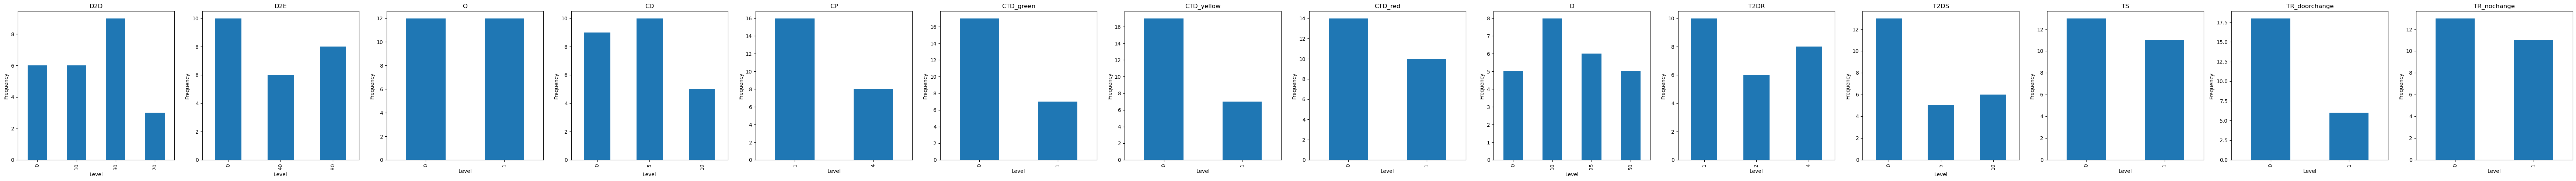

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Flatten the design matrix: A_* and B_* columns into single-level columns
flat_df = pd.DataFrame()
for alt in ['A', 'B']:
    cols = [col for col in opt_design.columns if col.startswith(f'{alt}_')]
    alt_df = opt_design[cols].copy()
    alt_df.columns = [col.replace(f'{alt}_', '') for col in cols]
    flat_df = pd.concat([flat_df, alt_df], axis=0)

# Setup subplot grid
num_cols = len(flat_df.columns)
fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(5 * num_cols, 5))

# Ensure axes is iterable even if num_cols == 1
if num_cols == 1:
    axes = [axes]

# Plot each attribute's level frequency
for i, col in enumerate(flat_df.columns):
    counts = flat_df[col].value_counts().sort_index()
    counts.plot(
        kind='bar',
        ax=axes[i],
        title=col
    )
    axes[i].set_xlabel("Level")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


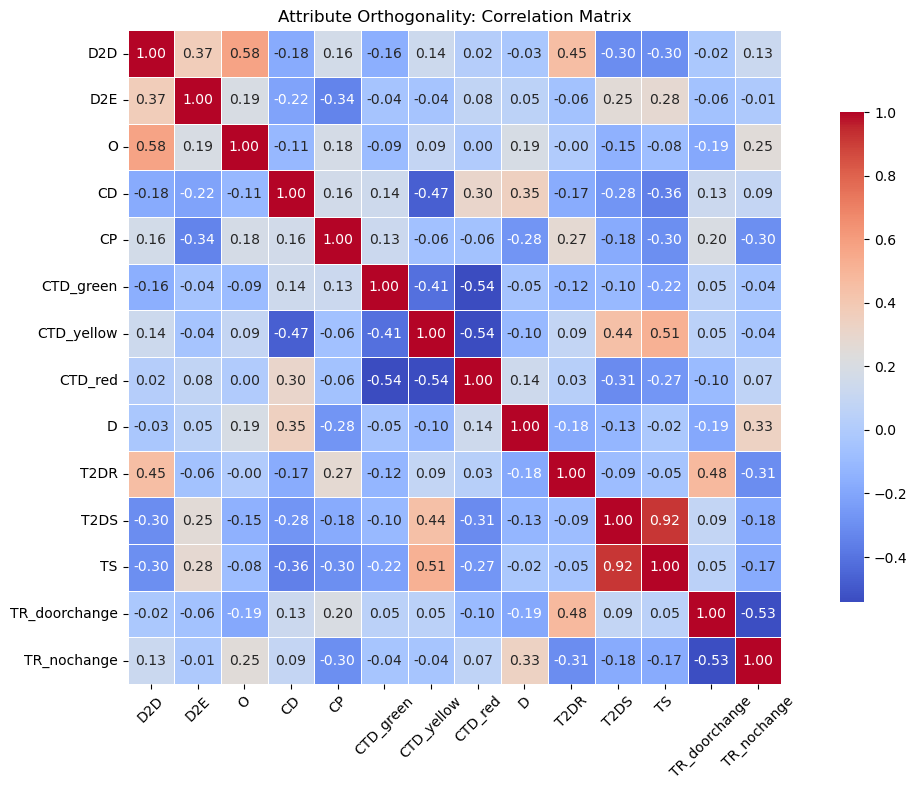

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten your design DataFrame (if not already)
# Example: flat_df = init_design.copy()
# Compute the correlation matrix
correlation_matrix = flat_df.corr()

# Set up the plot
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",       # Red-blue diverging colormap
    fmt=".2f",             # Format the annotations
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.75}
)

plt.title("Attribute Orthogonality: Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [15]:
# Define attribute directions: +1 = better, -1 = worse
attribute_directions = {
    'D2D': -1,
    'D2E': -1,
    'O': -1,
    'CD': -1,
    'CP': -1,
    'CTD_green': 1,
    'CTD_yellow': 1,
    'CTD_red': -1,
    'D': 1,
    'T2DR': -1,
    'T2DS': -1,
    'TS': 1,
    'TR_doorchange': 1,
    'TR_nochange': 1
}

# Normalize attribute values: higher = better
normalized_df = opt_design.copy()
for att, direction in attribute_directions.items():
    for alt in ['A', 'B']:
        col = f"{alt}_{att}"
        if col in normalized_df.columns:
            normalized_df[col] = direction * normalized_df[col]

# Perform dominance check row-by-row (choice set by choice set)
found_dominated = False

for i, row in normalized_df.iterrows():
    a_cols = [f"A_{att}" for att in attribute_directions if f"A_{att}" in row]
    b_cols = [f"B_{att}" for att in attribute_directions if f"B_{att}" in row]

    A_vals = row[a_cols].values
    B_vals = row[b_cols].values

    a_dominated = np.all(A_vals <= B_vals) and np.any(A_vals < B_vals)
    b_dominated = np.all(B_vals <= A_vals) and np.any(B_vals < A_vals)

    if a_dominated:
        print(f"⚠️ Dominated alternative in choice set {i + 1}: A is dominated by B")
        found_dominated = True
    elif b_dominated:
        print(f"⚠️ Dominated alternative in choice set {i + 1}: B is dominated by A")
        found_dominated = True

if not found_dominated:
    print("✅ No dominated alternatives found across all choice sets.")


✅ No dominated alternatives found across all choice sets.


In [17]:
def check_condition_compliance(design_df, cond_list, alt_labels=['A', 'B']):
    import pandas as pd

    def parse_condition(cond_str):
        """Convert a 'if ... then ...' rule to a Python-valid expression."""
        if 'if' in cond_str and 'then' in cond_str:
            cond_part = cond_str.split('then')[0].replace('if', '').strip()
            rule_part = cond_str.split('then')[1].strip()
            return f"~({cond_part}) | ({rule_part})"  # logical implication: if A then B ↔ ~A or B
        else:
            return cond_str  # treat as pure expression

    summary = {}
    violations = []

    for cond in cond_list:
        try:
            expr = parse_condition(cond)
            failed_rows = design_df[~design_df.eval(expr)]
            summary[cond] = len(failed_rows)

            if not failed_rows.empty:
                violations.append((cond, failed_rows))

        except Exception as e:
            print(f"⚠️ Error in evaluating condition:\n  {cond}\n  ⇨ Exception: {e}")
            summary[cond] = 'ERROR'

    print("\n📋 Condition Compliance Summary:")
    for rule, count in summary.items():
        if count == 0:
            print(f"✔️ {rule}")
        elif count == 'ERROR':
            print(f"⚠️ {rule} — Evaluation failed")
        else:
            print(f"❌ {rule} — {count} violations")

    return summary, violations
summary, violations = check_condition_compliance(opt_design, cond)


📋 Condition Compliance Summary:
✔️ A_T2DR == B_T2DR
✔️ ~(A_TS == 1) | (A_T2DS > 0)
✔️ ~(B_TS == 1) | (B_T2DS > 0)
✔️ ~(A_TS == 0) | (A_T2DS == 0)
✔️ ~(B_TS == 0) | (B_T2DS == 0)
✔️ ~((A_TS == 1) & (B_TS == 1)) | (A_T2DS == B_T2DS)
✔️ (A_TR_doorchange != 1) | (A_D <= 25)
✔️ (B_TR_doorchange != 1) | (B_D <= 25)
✔️ A_D2E != B_D2E
✔️ A_D2D != B_D2D
✔️ ~(A_D2D == 0) | (A_O == 0)
✔️ ~(B_D2D == 0) | (B_O == 0)
✔️ ~((A_D2D > B_D2D) & (B_O == 1)) | (A_O == 1)
✔️ ~((B_D2D > A_D2D) & (A_O == 1)) | (B_O == 1)
✔️ ~(A_D2D == 0) | (A_CP == 1)
✔️ ~(B_D2D == 0) | (B_CP == 1)
✔️ (A_CTD_green + A_CTD_yellow + A_CTD_red) == 1
✔️ (B_CTD_green + B_CTD_yellow + B_CTD_red) == 1
✔️ ~((A_TR_doorchange == 1) & (A_TR_nochange == 1))
✔️ ~((B_TR_doorchange == 1) & (B_TR_nochange == 1))


In [19]:
import os

# Get the path to the user's Downloads folder
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads")
file_path = os.path.join(downloads_path, "optimized_design.xlsx")

# Save to Excel
opt_design.to_excel(file_path, index=False)
print(f"Design saved to: {file_path}")

Design saved to: C:\Users\parit\Downloads\optimized_design.xlsx
